This notebook will be used for the Sentiment analysis and Topic Modeling of the tweets I have already downloaded
Think about demojinizing

In [83]:
%matplotlib ipympl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import emoji
import textblob
import spacy
from PIL import Image
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from spacy.tokenizer import Tokenizer
from wordcloud import wordcloud
#reading in the file of interest
tweets= pd.read_csv('/Users/Godfred King/Desktop/Python/Twitter Project/New Tweets.csv', on_bad_lines='skip', encoding='utf-8')

tweets=tweets.drop(['Unnamed: 0'], axis=1)
tweets.head()

,created_at,Tweets,id,converted_text
0,2022-09-25 14:08:02+00:00,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣 https://t.co/33uU2V5tLT,1574038019279134722,rolling_on_the_floor_laughing rolling_on_the...
1,2022-09-25 11:01:50+00:00,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣 https://t.co/yqzjQcDZdW,1573991159004889090,rolling_on_the_floor_laughing rolling_on_the...
2,2022-09-21 22:21:00+00:00,🤣🤣🤣🤣🤣🤣 https://t.co/GzsasvV5mR,1572712527297155073,rolling_on_the_floor_laughing rolling_on_the...
3,2022-09-21 20:32:39+00:00,@kwabena_marvin That's the GOAT,1572685258285551617,@kwabena_marvin That's the GOAT
4,2022-09-19 09:46:55+00:00,@Gibril_jnr @DukuGyimah My brother. Be careful,1571797978767040515,@Gibril_jnr @DukuGyimah My brother. Be careful


In [84]:
#Converting the created_at column to a datetime field
tweets['created_at']= pd.to_datetime(tweets['created_at'],utc=False)
tweets['hour']= tweets['created_at'].dt.hour
tweets['Days of the week']=tweets['created_at'].dt.day_name()
tweets['Month']= tweets['created_at'].dt.month_name()
tweets.head()

,created_at,Tweets,id,converted_text,hour,Days of the week,Month
0,2022-09-25 14:08:02+00:00,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣 https://t.co/33uU2V5tLT,1574038019279134722,rolling_on_the_floor_laughing rolling_on_the...,14,Sunday,September
1,2022-09-25 11:01:50+00:00,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣 https://t.co/yqzjQcDZdW,1573991159004889090,rolling_on_the_floor_laughing rolling_on_the...,11,Sunday,September
2,2022-09-21 22:21:00+00:00,🤣🤣🤣🤣🤣🤣 https://t.co/GzsasvV5mR,1572712527297155073,rolling_on_the_floor_laughing rolling_on_the...,22,Wednesday,September
3,2022-09-21 20:32:39+00:00,@kwabena_marvin That's the GOAT,1572685258285551617,@kwabena_marvin That's the GOAT,20,Wednesday,September
4,2022-09-19 09:46:55+00:00,@Gibril_jnr @DukuGyimah My brother. Be careful,1571797978767040515,@Gibril_jnr @DukuGyimah My brother. Be careful,9,Monday,September


Going to try to extract all of the distinct emojis and in  the tweets and demojize them so I can better standardize them to have a better impact on the sentiment analysis and topic modelling

In [85]:
distinct_emojis= [emoji.distinct_emoji_list(col) for col in tweets['Tweets']]
distinct_emojis[:10]
emo_list=list(distinct_emojis[0][0])
for lst in distinct_emojis:
    if len(lst)==0:
        continue
    else:
        for emo in lst:
            if emo in emo_list:
                continue
            else:
                emo_list.append(emo)
emo_list
emo_dict={}
for emo in emo_list:
    emo_dict[emo]=emoji.demojize(emo)
  

Had to personally add some stopwords. Words that are frequently used in pidgin because some of the tweets are in Pidgin and not conventional English.

In [86]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both','barb', 'by', 'can', 'd', 'did', 'do','dey',
             'does', 'doing', 'down', 'during','ein', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was','us',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves','rt','oh', 'aren','nah','ah','ei','want','jnr',"dessieray"]
nlp= spacy.load('en_core_web_lg')      

stopwords= nlp.Defaults.stop_words.union(stopwordlist)

In [87]:
#Defining the needed functions for data cleaning

def standard_emoji(col):
    '''Converting the demojinized text into a form that can be used for the sentiment analysis and the topic modeling'''
    if re.findall('rolling_on_the_floor_laughing',col):
        return col.replace('rolling_on_the_floor_laughing',"hilarious")
    elif re.findall('person_facepalming',col):
        return col.replace('person_facepalming', 'disappointed')
    elif re.findall('grinning_face_with_sweat',col):
        return col.replace('grinning_face_with_sweat','smile')
    elif re.findall('loudly_crying_face',col):
        return col.replace('loudly_crying_face', 'sad')
    elif re.findall('face_with_tears_of_joy',col):
        return col.replace('face_with_tears_of_joy','hilarious')
    elif re.findall('partying_face',col):
        return col.replace('partying_face', 'excited')
    elif re.findall('smiling_face',col):
        return col.replace('smiling_face','happy')
    elif re.findall('smiling_face_with_heart-eyes',col):
        return col.replace('smiling_face_with_heart-eyes','love')
    elif re.findall('grinning_squinting_face',col):
        return col.replace('grinning_squinting_face','funny')
    elif re.findall('skull_and_crossbones',col):
        return col.replace('skull_and_crossbones','scary')
    elif re.findall('face_with_rolling_eyes',col):
        return col.replace('face_with_rolling_eyes','unbothered')
    elif re.findall('red_heart',col):
        return col.replace('red_heart','love')
    elif re.findall('grinning_face',col):
        return col.replace('grinning_face','happy')
    elif re.findall('pensive_face',col):
        return col.replace('pensive_face','sad')
    elif re.findall('flushed_face',col):
        return col.replace('flushed_face','surprised')
    elif re.findall('hundred_points',col):
        return col.replace('hundred_points','agree')
    elif re.findall('folded_hands_medium-dark_skin_tone',col):
        return col.replace('folded_hands_medium-dark_skin_tone','hopeful')
    elif re.findall('folded_hands_medium-dark_skin_tone|folded_hands',col):
        return col.replace('folded_hands_medium-dark_skin_tone','hopeful')
    elif re.findall('thinking_face',col):
        return col.replace('thinking_facee','confused')
    elif re.findall('crossed_fingers',col):
        return col.replace('crossed_fingers','hopeful')
    elif re.findall('broken_heart',col):
        return col.replace('broken_heart','sad')
    else:
        return col    


def clean_tweet(col):
    '''Removing hyperlinks and special characters from the tweets'''
    return ' '. join(re.sub(r'(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|([A-Za-z0-9]+:\/\/\S+)',' ',col).split())


def format_hour(hour):
    '''Takes the hour extracted from the timestamp and formats it as time'''
    return str(hour)+':00'

def remove_numbers(col):
    '''remove numbers from tweets'''
    return ' '.join(re.sub('[0-9]+',' ',col).split())

def remove_stopwords(col):
    '''Removing stopwords from the tweets'''
    col= col.lower()
    words= col.split()
    new_words=[]
    for word in words:
        if word in stopwordlist:
            new_words.append(' ')
        else:
            new_words.append(word)
    return ' '.join(new_words  )  

def standard_goal(col):
    '''Standardization of the different spelling of goals in the tweets'''
    col= col.lower()
    words= col.split()
    new_words=[]
    for word in words:
        if word.startswith('g') and word.endswith('l') and 'oa' in word:
            new_words.append('goal')
        else:    
            new_words.append(word)
    return ' '.join(new_words)         
def standard_laugh(col):
    '''Remove unneccessary repittion of the words from the column
    eg removing multiple statements of hilarious from the dataframe'''
    words= col.split()
    if len(set(words))==1:
        return words[0]
    else:
        return col    

def remove_emoji(col):
    '''Remove emoji from a tweets'''
    emoji_free= [word for word in col if word not in emoji.distinct_emoji_list(col)]
    return  ''.join(emoji_free)

    
   

In [88]:
#Applying the user defined functions
tweets['removed emojis']= tweets['converted_text'].apply(standard_emoji)
tweets['formatted tweets']= tweets['removed emojis'].apply(clean_tweet)
tweets['formatted tweets']= tweets['formatted tweets'].apply(remove_numbers)
tweets['formatted tweets']= tweets['formatted tweets'].apply(standard_goal)

tweets['formatted tweets']= tweets['formatted tweets'].apply(remove_stopwords)
tweets['formatted tweets']= tweets['formatted tweets'].apply(standard_laugh)

tweets.head()


,created_at,Tweets,id,converted_text,hour,Days of the week,Month,removed emojis,formatted tweets
0,2022-09-25 14:08:02+00:00,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣 https://t.co/33uU2V5tLT,1574038019279134722,rolling_on_the_floor_laughing rolling_on_the...,14,Sunday,September,hilarious hilarious hilarious hilarious h...,hilarious
1,2022-09-25 11:01:50+00:00,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣 https://t.co/yqzjQcDZdW,1573991159004889090,rolling_on_the_floor_laughing rolling_on_the...,11,Sunday,September,hilarious hilarious hilarious hilarious h...,hilarious
2,2022-09-21 22:21:00+00:00,🤣🤣🤣🤣🤣🤣 https://t.co/GzsasvV5mR,1572712527297155073,rolling_on_the_floor_laughing rolling_on_the...,22,Wednesday,September,hilarious hilarious hilarious hilarious h...,hilarious
3,2022-09-21 20:32:39+00:00,@kwabena_marvin That's the GOAT,1572685258285551617,@kwabena_marvin That's the GOAT,20,Wednesday,September,@kwabena_marvin That's the GOAT,marvin goat
4,2022-09-19 09:46:55+00:00,@Gibril_jnr @DukuGyimah My brother. Be careful,1571797978767040515,@Gibril_jnr @DukuGyimah My brother. Be careful,9,Monday,September,@Gibril_jnr @DukuGyimah My brother. Be careful,brother careful


c:\Users\Godfred King\AppData\Local\Programs\Python\Python39\lib\site-packages\ipywidgets\widgets\widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
c:\Users\Godfred King\AppData\Local\Programs\Python\Python39\lib\site-packages\ipywidgets\widgets\widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


Text(0.5, 1.0, 'Frequency distribution of Tweets by Hour')

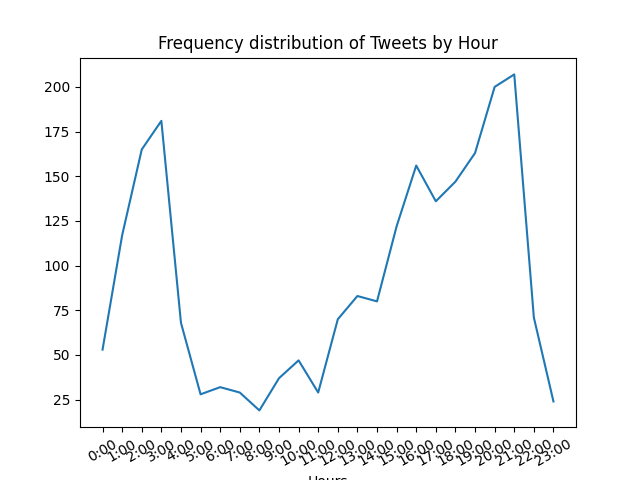

In [90]:
#Hour distribution( Distribution of the tweets by hour)
hours= tweets.groupby(['hour']).aggregate('count')



hours= hours.reset_index()

hours['hour']= hours['hour'].apply(format_hour)    

plt.figure()
plt.plot(hours['hour'],hours['created_at'])
plt.xticks(rotation=30);
plt.xlabel('Hours')
plt.title('Frequency distribution of Tweets by Hour')



c:\Users\Godfred King\AppData\Local\Programs\Python\Python39\lib\site-packages\ipywidgets\widgets\widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
c:\Users\Godfred King\AppData\Local\Programs\Python\Python39\lib\site-packages\ipywidgets\widgets\widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


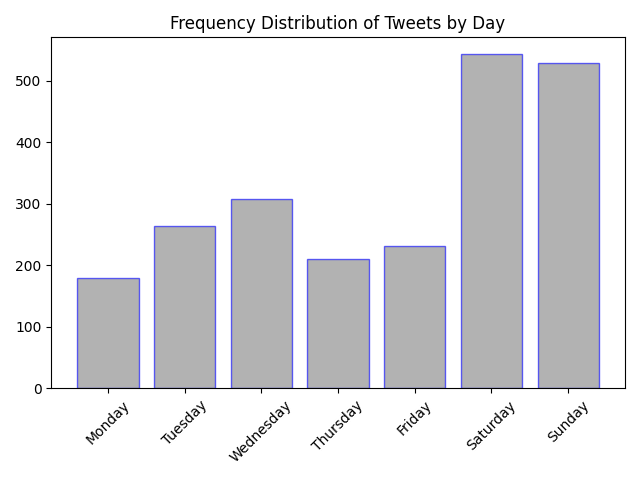

In [91]:
#Day Distribution of the tweets
day = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

#Days of the week Distribution
days= tweets.groupby(['Days of the week']).agg({'Days of the week':np.count_nonzero})
days=days.rename({'Days of the week':'Count'}, axis=1).reset_index()

days['num_day']= days['Days of the week'].apply(lambda x:day.index(x))
days= days.sort_values(by=['num_day'], ascending=True)


plt.figure()
x_vals= range(0,len(days))
plt.bar(days['Days of the week'], days['Count'], color='grey', alpha=0.6, edgecolor='blue')
plt.xticks(rotation=45);
plt.title('Frequency Distribution of Tweets by Day')
plt.tight_layout()



c:\Users\Godfred King\AppData\Local\Programs\Python\Python39\lib\site-packages\ipywidgets\widgets\widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
c:\Users\Godfred King\AppData\Local\Programs\Python\Python39\lib\site-packages\ipywidgets\widgets\widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


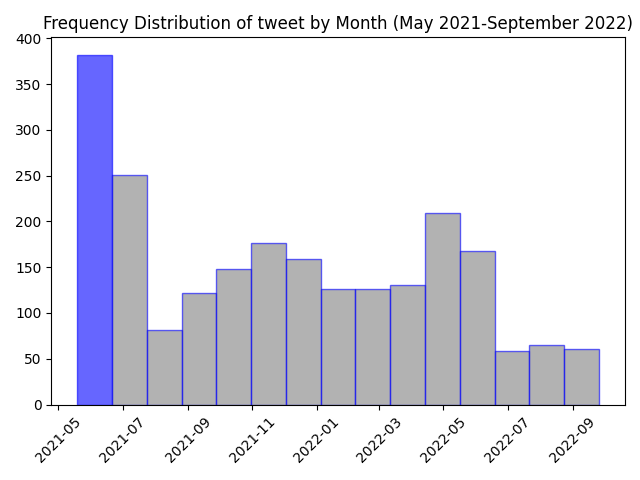

In [77]:
#Month distribution of the tweets

plt.figure()
n, bins, patches=plt.hist(tweets['created_at'], bins=15, color='grey',alpha=0.6, edgecolor='blue');
patches[0].set_fc('b')
plt.xticks(rotation=45)
plt.title('Frequency Distribution of tweet by Month (May 2021-September 2022)');
plt.tight_layout()



Looks like I did a lot of tweeting around May 2021- July 2021. I think we were on vacation around that time and the NBA playoffs were going on as well as the Champions league finals. AHa. Thats craaaazy

In [64]:
print('The first tweeet for this analysis was on {}'. format(tweets['created_at'].min()))
print('The last tweet for this analysis was on {}'.format(tweets['created_at'].max()))

The first tweeet for this analysis was on 2021-05-18 18:55:54+00:00
The last tweet for this analysis was on 2022-09-25 14:08:02+00:00


Removal of unneccesary columns to leave on the converted text and the time of creation in the data frame. Also rename the converted text column to tweets

In [65]:
tweets=tweets[['created_at', 'Tweets','formatted tweets','removed emojis']]
tweets= tweets.rename({'formatted tweets':'tweet', 'Tweets':'original_tweet'}, axis=1)
tweets.head()

,created_at,original_tweet,tweet,removed emojis
0,2022-09-25 14:08:02+00:00,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣 https://t.co/33uU2V5tLT,hilarious,hilarious hilarious hilarious hilarious h...
1,2022-09-25 11:01:50+00:00,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣 https://t.co/yqzjQcDZdW,hilarious,hilarious hilarious hilarious hilarious h...
2,2022-09-21 22:21:00+00:00,🤣🤣🤣🤣🤣🤣 https://t.co/GzsasvV5mR,hilarious,hilarious hilarious hilarious hilarious h...
3,2022-09-21 20:32:39+00:00,@kwabena_marvin That's the GOAT,marvin goat,@kwabena_marvin That's the GOAT
4,2022-09-19 09:46:55+00:00,@Gibril_jnr @DukuGyimah My brother. Be careful,brother careful,@Gibril_jnr @DukuGyimah My brother. Be careful


Getting a list of those I talk to a lot by finding those @s in my tweets. Plan is to generate a histogram with that

c:\Users\Godfred King\AppData\Local\Programs\Python\Python39\lib\site-packages\ipywidgets\widgets\widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
c:\Users\Godfred King\AppData\Local\Programs\Python\Python39\lib\site-packages\ipywidgets\widgets\widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


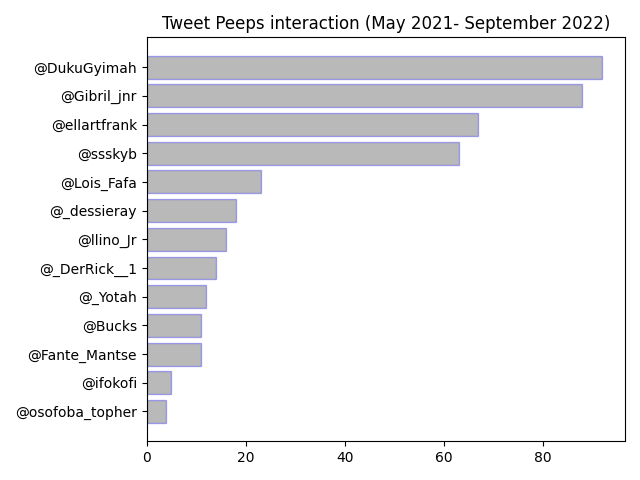

In [78]:
tweet_to=[]
for tweet in tweets.original_tweet:
    
    if re.findall(r'@\w+',tweet):
        tweet_to.append(re.findall(r'@\w+',tweet))

tweet_buddies=[buddie[0] for buddie in tweet_to]  

#Had to merge Gibril Junior and Havertz papa into one becuase its the same person. Its Agent Samusah    

edit_buds=['@Gibril_jnr' if buddie =='@havertz_papa' else buddie for buddie in tweet_buddies]

buddies_dict={}
for buddie in edit_buds:
    buddies_dict[buddie]= buddies_dict.get(buddie,0)+1
    


buddies_df= pd.DataFrame(list(buddies_dict.items()), columns=['Twitter Handle','Frequency'])
buddies_df=buddies_df[buddies_df['Frequency']>3].reset_index()\
    .drop(['index'],axis=1).sort_values('Frequency')

xvalues=range(0, len(buddies_df))
plt.figure()
plt.barh(xvalues, buddies_df['Frequency'],alpha=0.3,color=(0.1,0.1,0.1,0.1),edgecolor='blue')
plt.yticks(xvalues, buddies_df['Twitter Handle'],rotation=0)
plt.title('Tweet Peeps interaction (May 2021- September 2022)')
plt.tight_layout()



Sentiment Analysis for my tweets between May 2021- September 2022
#For some reason, Laughther and Laughing are considered as neutral sentiment which is a bit counter intuitive to me. I feel these are supposed to be positive sentiments rather

In [67]:
sentiment= textblob.TextBlob("rolling_on_the_floor_laughing")
print(sentiment.sentiment.polarity)

0.0


In [68]:
#Getting the Sentiment for each of the tweets in the dataframe using a function
def sentiment_gen(col):
    '''Determines the sentiment polarity for each of the tweets'''

    sentiment= textblob.TextBlob(col)
    
    return sentiment.sentiment.polarity
tweets['Polarity']= tweets['removed emojis'].apply(sentiment_gen)

tweets[tweets['Polarity']>0]


,created_at,original_tweet,tweet,removed emojis,Polarity
0,2022-09-25 14:08:02+00:00,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣 https://t.co/33uU2V5tLT,hilarious,hilarious hilarious hilarious hilarious h...,0.500000
1,2022-09-25 11:01:50+00:00,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣 https://t.co/yqzjQcDZdW,hilarious,hilarious hilarious hilarious hilarious h...,0.500000
2,2022-09-21 22:21:00+00:00,🤣🤣🤣🤣🤣🤣 https://t.co/GzsasvV5mR,hilarious,hilarious hilarious hilarious hilarious h...,0.500000
6,2022-09-17 23:43:06+00:00,Finally got approved lol,finally got approved lol,Finally got approved lol,0.400000
7,2022-09-17 23:42:19+00:00,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣 https://t.co/wRYuSm2mpW,hilarious,hilarious hilarious hilarious hilarious h...,0.500000
...,...,...,...,...,...
2244,2021-05-20 02:29:23+00:00,@DukuGyimah 😂😂😂😂,hilarious,@DukuGyimah hilarious hilarious hilarious ...,0.500000
2245,2021-05-19 19:12:54+00:00,It better be a really good game. Hmm,better really good game hmm,It better be a really good game. Hmm,0.266667
2247,2021-05-19 17:24:21+00:00,YOOOOOOOOO I'M CRYING😂😂😂😂😂😂 https://t.co/cBbB2...,yooooooooo crying hilarious hilarious hila...,YOOOOOOOOO I'M CRYING hilarious hilarious hi...,0.400000
2251,2021-05-18 21:12:56+00:00,Good game,good game,Good game,0.150000


In [69]:
#Showing the percentage of tweets that were classified as being positive , negative and neutral
pos_tweets= len(tweets[tweets['Polarity']>0])
neg_tweets= len(tweets[tweets['Polarity']<0])
neutral= len(tweets[tweets['Polarity']==0])

print('Percentage of positive tweets {}'.format(pos_tweets/len(tweets)*100))
print('Percentage of negative tweets {}'.format(neg_tweets/len(tweets)*100))
print('Percentage of neutral tweets {}'.format(neutral/len(tweets)*100))

Percentage of positive tweets 39.840989399293285
Percentage of negative tweets 13.427561837455832
Percentage of neutral tweets 46.73144876325088


Topic Modeling 
I have to download some packages now and I cannot do that with my bundle so I will wait until tomorrow to do that at work 

Lets Build a Word Cloud with what we have now

I have to iterate over everything in the corpus to break it down into individual words and then create the dictionary to be used for the Word Cloud

In [70]:

import nltk
from nltk.stem import WordNetLemmatizer
corpus = tweets['tweet'].to_list()
lemma= WordNetLemmatizer()
wordlist=[]
for i in range(len(corpus)):
    words= nltk.word_tokenize(corpus[i].lower())
    for word in words:
        if word not in stopwords:
            wordlist.append(lemma.lemmatize(word))




word_freq={}
for word in wordlist:
    word_freq[word]=word_freq.get(word,0)+1


c:\Users\Godfred King\AppData\Local\Programs\Python\Python39\lib\site-packages\ipywidgets\widgets\widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
c:\Users\Godfred King\AppData\Local\Programs\Python\Python39\lib\site-packages\ipywidgets\widgets\widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


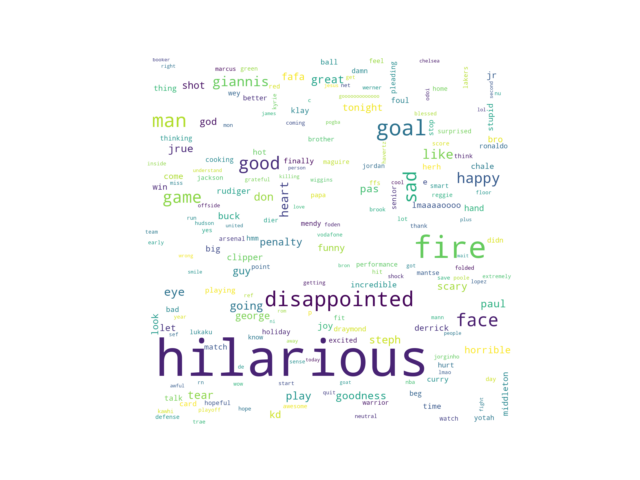

In [79]:
#Getting the data needed for the Word Cloud
mask= np.array(Image.open('/Users/Godfred King/Desktop/Python/Twitter Project/g.png'))

def transform_format(val):
    if val>150:
        return 0
    else:
        return val

transformed_mask= np.ndarray((mask.shape[0],mask.shape[1]),np.int32)   
for i in range(len(mask)):
    transformed_mask[i]= list(map(transform_format, mask[i]))

cloud = wordcloud.WordCloud(background_color='white', max_words=200, mode='RGBA',mask=transformed_mask,stopwords=stopwordlist).generate_from_frequencies(word_freq)
plt.figure()
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off');
# plt.show()


Topic Modeling. To do the topic modeling, I decided to include the retweeted tweets for the Analysis since it was going to give an idea of the kind of topics I generally engaged with.
As an aside, I am going to try to plot a histogram to show the various accounts I retweeted for the tweets that I have

In [72]:
#Getting the data frame which includes the retweets
tm_df= pd.read_csv('/Users/Godfred King/Desktop/Python/Twitter Project/God.csv', on_bad_lines='skip', encoding='utf-8')
#Pulling out the retweeted tweets in the dataframe
retweets= tm_df[tm_df['Tweets'].str.startswith('RT')]
retweets['Retweet Handle']= retweets['Tweets'].apply(lambda x: re.findall('@[A-Za-z0-9]+',x))


C:\Users\Godfred King\AppData\Local\Temp\ipykernel_15696\782691600.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retweets['Retweet Handle']= retweets['Tweets'].apply(lambda x: re.findall('@[A-Za-z0-9]+',x))


c:\Users\Godfred King\AppData\Local\Programs\Python\Python39\lib\site-packages\ipywidgets\widgets\widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
c:\Users\Godfred King\AppData\Local\Programs\Python\Python39\lib\site-packages\ipywidgets\widgets\widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


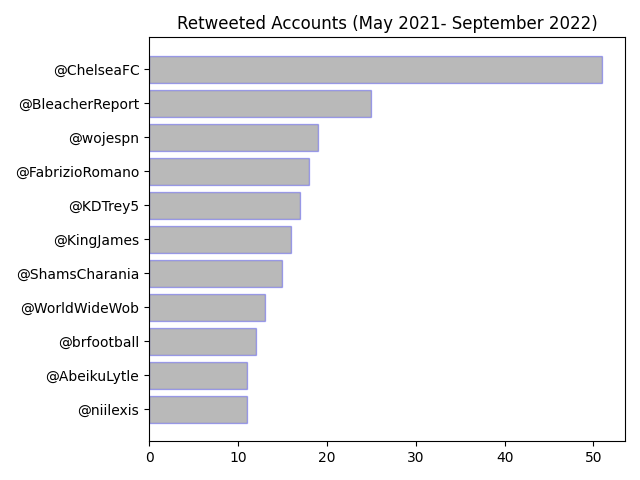

In [80]:
handles=retweets['Retweet Handle'].to_list()

"""
Checks the length of each of the handles for each column in the dataframe
If the len == 1, it checks the dictionary to see if it is already a key 
then adds 1 to the value.
if not the key is added to the dictionary and the value is set to one

If there are multiple handles for one tweets, we iterate over all of them and then
repeat the process of checking with the dictionalry 

"""
handle_dict={}
for handle in handles:
    if len(handle)==1:
        handle_dict[handle[0]]=handle_dict.get(handle[0],0)+1
    else:
        for hand in handle:
            handle_dict[hand]=handle_dict.get(hand,0)+1    




handle_df= pd.DataFrame(list(handle_dict.items()), columns=['Twitter Handle','Frequency'])
tophandle=handle_df[handle_df['Frequency']>10]

tophandle=tophandle[tophandle['Frequency']>3].reset_index()\
    .drop(['index'],axis=1).sort_values('Frequency')

xvalues=range(0, len(tophandle))
plt.figure()
plt.barh(xvalues, tophandle['Frequency'],alpha=0.3,color=(0.1,0.1,0.1,0.1),edgecolor='blue')
plt.yticks(xvalues, tophandle['Twitter Handle'],rotation=0)
plt.title('Retweeted Accounts (May 2021- September 2022)')
plt.tight_layout()

In [74]:
tm_df['emoji free']= tm_df['Tweets'].apply(remove_emoji)
tm_df['clean tweet']= tm_df['emoji free'].apply(clean_tweet)
tm_df['clean tweet']= tm_df['clean tweet'].apply(standard_goal)

tm_df.head(5)

,Unnamed: 0,created_at,Tweets,id,emoji free,clean tweet
0,0,2022-10-16 17:15:30+00:00,@Gibril_jnr 🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,1581695340742262784,@Gibril_jnr,jnr
1,1,2022-10-16 15:36:56+00:00,Wild https://t.co/pXWLc5xZiq,1581670535129620482,Wild https://t.co/pXWLc5xZiq,wild
2,2,2022-10-16 14:12:59+00:00,@Gibril_jnr Oh nah. My personal things I dey do,1581649409896747008,@Gibril_jnr Oh nah. My personal things I dey do,jnr oh nah my personal things i dey do
3,3,2022-10-16 14:08:43+00:00,This is such a huge milestone for me and I am ...,1581648334418169860,This is such a huge milestone for me and I am ...,this is such a huge milestone for me and i am ...
4,4,2022-10-16 07:15:58+00:00,@kwabena_marvin 🤣🤣🤣🤣🤣🤣🤣,1581544465462095872,@kwabena_marvin,marvin


Tokenization of the the Tweets

In [50]:
def tokenize(col):
    '''Tokenize the words in the columns'''
    words=nltk.word_tokenize(col.lower())
    return [word for word in words if word not in stopwords]


def lemmatize(col):
    '''Lemmatizes each of the words and returns a string of the lemmatized text '''
    lemmatized=[]
    for word in col:
        lemmatized.append(lemma.lemmatize(word))
    return ' '.join(lemmatized)


    
tm_df['tokens']= tm_df['clean tweet'].apply(tokenize)
tm_df['lemmatize']= tm_df['tokens'].apply(lemmatize)


In [51]:
#Create Dictionary 

text= tm_df.lemmatize.to_list()
words=[word.split() for word in text]
final_words=[]
for word in words:
    if len(word)>0:
        final_words.append(word)
    else:
        continue

dictionary= corpora.Dictionary(final_words)

word_term_matrix=[dictionary.doc2bow(words) for words in final_words]

#Creating the object of the LDA model on the document term matrix
lda= gensim.models.ldamodel.LdaModel
ldamodel= lda(word_term_matrix, num_topics=5,id2word=dictionary, passes=50)

print(ldamodel.print_topics(num_topics=5, num_words=5))



[(0, '0.031*"game" + 0.011*"win" + 0.011*"3" + 0.008*"buck" + 0.008*"point"'), (1, '0.010*"league" + 0.010*"time" + 0.010*"big" + 0.009*"chelsea" + 0.007*"giannis"'), (2, '0.022*"paul" + 0.021*"george" + 0.018*"giannis" + 0.014*"jrue" + 0.012*"buck"'), (3, '0.024*"goal" + 0.015*"like" + 0.015*"man" + 0.013*"good" + 0.009*"e"'), (4, '0.011*"god" + 0.009*"goodness" + 0.009*"penalty" + 0.008*"game" + 0.007*"thank"')]


In [52]:
pyLDAvis.enable_notebook()
tmvis= gensimvis.prepare(ldamodel,word_term_matrix,dictionary)
tmvis

c:\Users\Godfred King\AppData\Local\Programs\Python\Python39\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.056387 -0.178885       1        1  25.592177
0      0.113787  0.108464       2        1  19.730393
2     -0.188979  0.106691       3        1  18.878336
4      0.062320 -0.035439       4        1  18.751557
1      0.069261 -0.000831       5        1  17.047537, topic_info=         Term        Freq       Total Category  logprob  loglift
270      goal   69.000000   69.000000  Default  30.0000  30.0000
3215     paul   47.000000   47.000000  Default  29.0000  29.0000
3532   george   45.000000   45.000000  Default  28.0000  28.0000
87       game  101.000000  101.000000  Default  27.0000  27.0000
1450     jrue   30.000000   30.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
401       win    7.716260   32.457680   Topic5  -5.5258   0.3326
28        don    8.122408   48.487465   Topic5  -5.4745  -0.0175
143    season    6.528942   18.069402   Topic5  -5.6929   0.7512
88      going    6.745972   45.985065   Topic5  -5.6602  -0.1502
628   playing    6.282795   16.219144   Topic5  -5.7313   0.8208

[284 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
640       1  0.787815     1
640       2  0.131303     1
640       4  0.065651     1
264       4  0.927595    13
777       1  0.287743     2
...     ...       ...   ...
78        2  0.169226  year
78        3  0.270762  year
78        4  0.338452  year
78        5  0.169226  year
286       3  0.976456   yes

[359 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 5, 2])

This is the end. It has been an incredible couple of weeks trying to get this done. Let's gooooooo.
I wish I had the access to my all of my tweets instead of the last 3200 tweets and retweets

In [53]:
pyLDAvis.save_html(tmvis,'lda.html')